In [3]:
# !pip install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import io
import re

In [4]:
DATA_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

PATT = re.compile(r'---BEGIN DUMP---([\S\n.]*?)---END DUMP---')

def read_log(filename, name):
    def attach_info(df, n):
        df['name'] = name
        df['n'] = n
        return df
        
    with open(filename, 'r') as f:
        raw_data = f.read()
    # blocks = [b for b in raw_data.split(HEADER) if b]
    matches = PATT.finditer(str(raw_data))
    return pd.concat([attach_info(pd.read_csv(io.StringIO(m.group(1))), n) for n, m in enumerate(matches)])

In [30]:
df = pd.concat((
    read_log(f, n)
    for (f, n) in [
        ('./data/52hz/circles.csv', 'circle'),
        ('./data/52hz/z.csv', 'z'),
    ]
))

In [31]:
df

,ax,ay,az,gx,gy,gz,name,n
0,5457,442,20922,-3675,1048,-3771,circle,0
1,3834,839,21202,-5454,2638,-4950,circle,0
2,2294,510,25117,-6452,2623,-6284,circle,0
3,-110,10,27823,-6444,3697,-7275,circle,0
4,-3324,-47,28708,-6259,5284,-7891,circle,0
...,...,...,...,...,...,...,...,...
123,-934,-588,16570,565,-300,229,z,4
124,-774,-981,17209,666,-588,-59,z,4
125,-740,-1345,17138,305,-495,-194,z,4
126,-681,-1131,17116,199,-337,-5,z,4


In [32]:
def plot_mov(df, name, n, ax):
    df[
        (df.name == name) & (df.n == n)
    ][['ax', 'ay', 'az', 'gx', 'gy', 'gz']].plot(ax=ax)
    ax.set_title(f'{name} #{n}')

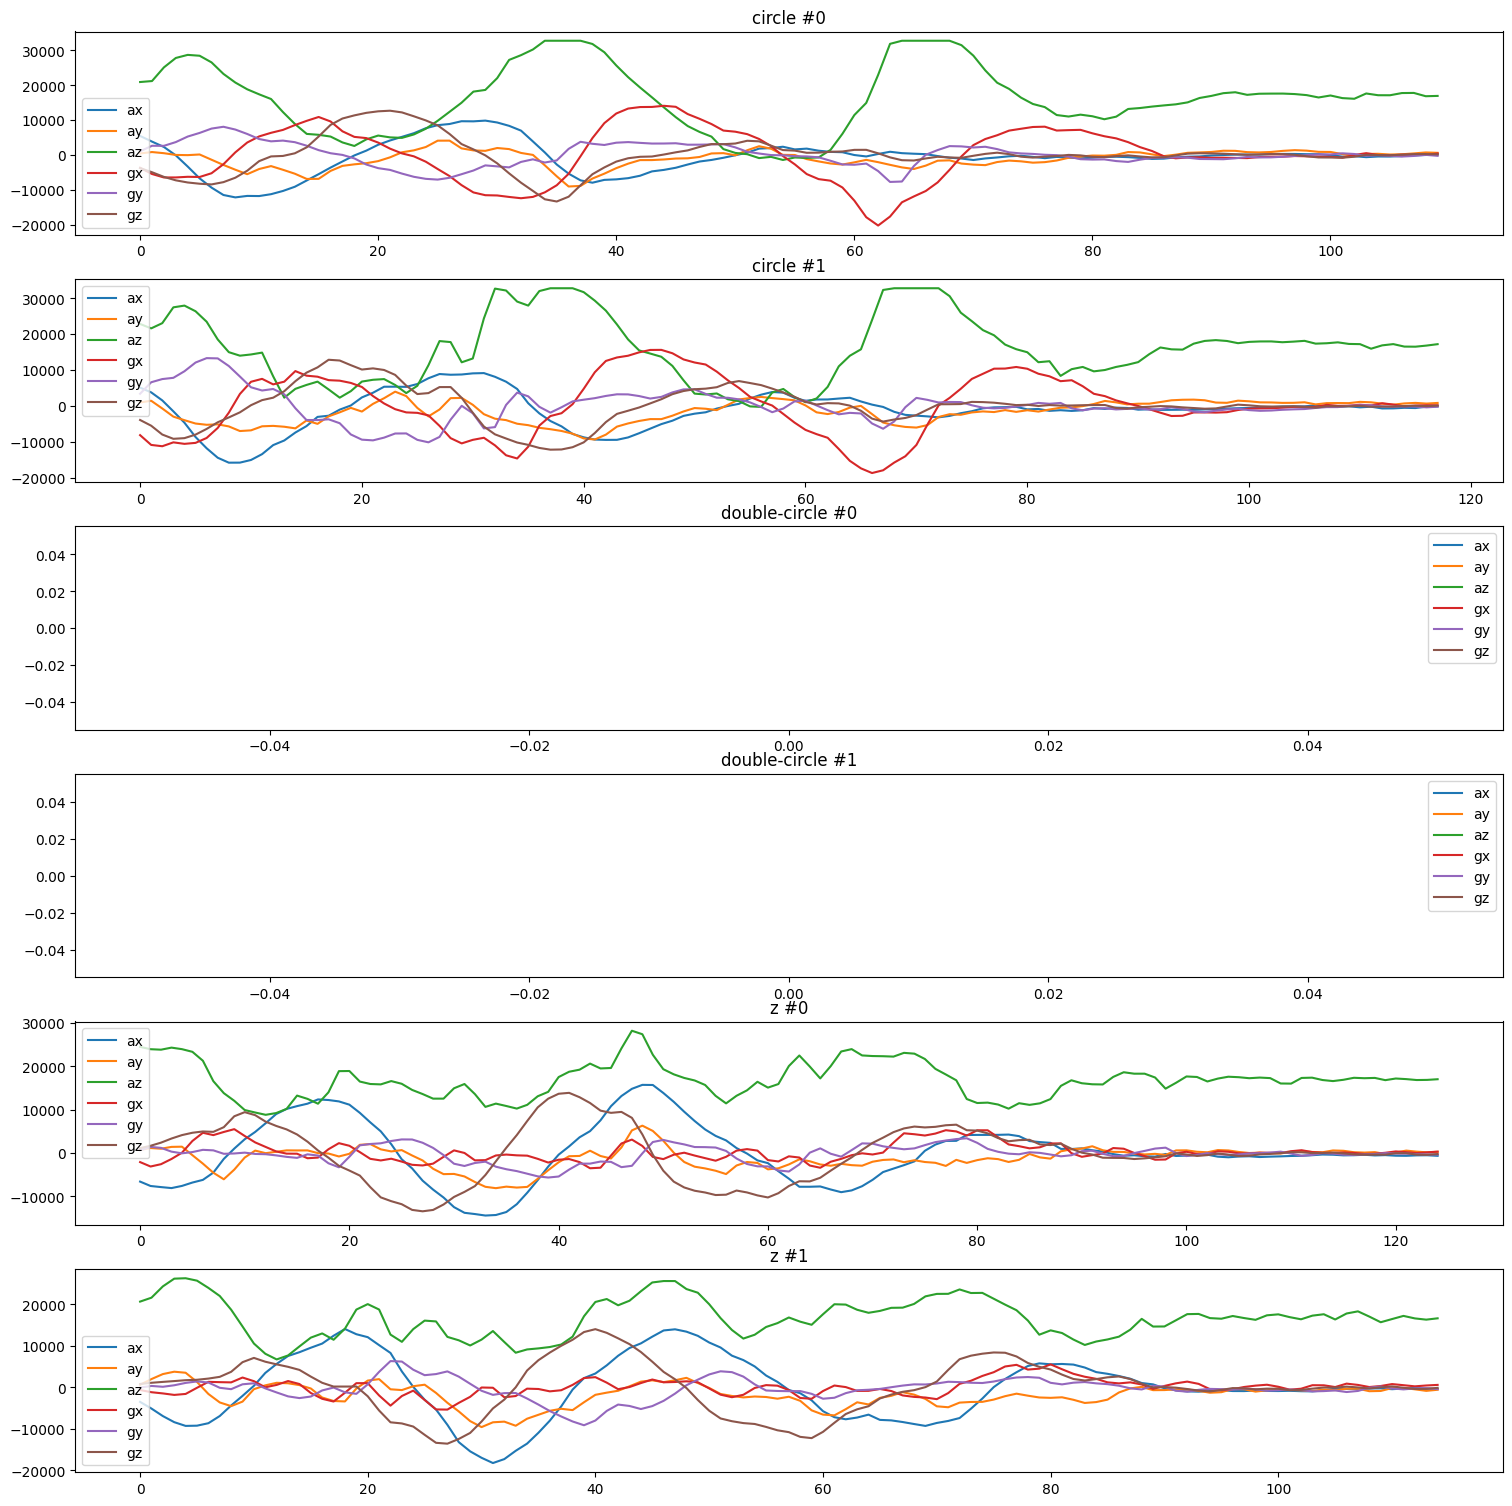

In [33]:
N_EACH = 2

fig, axs = plt.subplots(3 * N_EACH, 1, figsize=(15, 15))
fig.tight_layout()

for i in range(N_EACH):
    plot_mov(df, 'circle', i, axs[i])

for i in range(N_EACH):
    plot_mov(df, 'double-circle', i, axs[i + N_EACH])
    
for i in range(N_EACH):
    plot_mov(df, 'z', i, axs[i + 2 * N_EACH])


In [34]:
#!pip install dtw-python
# !pip install seaborn dtw-python

In [35]:
import dtw

# https://dynamictimewarping.github.io/python/

In [37]:
from scipy.spatial.distance import cdist

X = np.random.rand(10, 6)
Y = np.random.rand(10, 6)

cdist(X, Y)

array([[1.10309028, 1.33316146, 0.89707562, 1.31366714, 1.36392262,
        1.31044708, 1.36035703, 1.57344758, 1.1342245 , 0.6513511 ],
       [1.49954923, 1.43436584, 0.91158095, 0.53644529, 1.34239831,
        1.06195358, 0.98308908, 1.22859641, 1.41280117, 0.87386291],
       [1.38065232, 1.42561303, 1.09816559, 0.56872109, 1.21936517,
        0.79579473, 0.7566338 , 1.17529765, 1.39535172, 0.8373618 ],
       [1.05695567, 0.972906  , 1.06105161, 1.00711118, 0.34479195,
        1.11312274, 1.03096202, 0.96187877, 1.34399629, 1.26440505],
       [0.78979127, 0.86025212, 1.12290218, 1.11516545, 0.69559772,
        0.73876741, 0.73851541, 0.64213889, 0.95328535, 0.94278959],
       [1.02357233, 0.53307049, 0.81819526, 1.19909785, 1.08866346,
        1.01611389, 1.1859642 , 0.76265016, 0.9465095 , 0.90987667],
       [1.32444992, 1.09430339, 0.73796175, 0.6789497 , 0.88284242,
        1.22110792, 1.01761838, 0.7581949 , 1.27477015, 1.15442458],
       [1.31247299, 1.19108341, 1.3297053

In [38]:
cdist(dfs[0], dfs[1]).shape

(98, 103)

Text(0, 0.5, 'z #5')

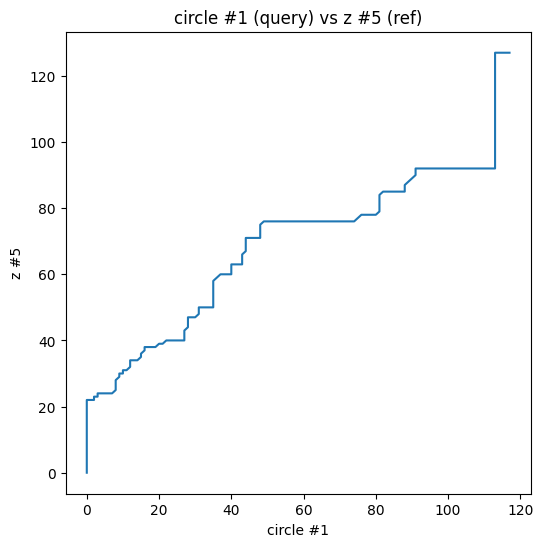

In [39]:
# res = dtw.dtw(dfs[0], dfs[6])
# res.plot()
# res.normalizedDistance

def mov_df(df, name, n):
    return df[(df.name == name) & (df.n == n)][DATA_COLS]

res = dtw.dtw(
    # Query.
    mov_df(df, 'circle', 1),
    # Reference.
    mov_df(df, 'z', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs z #5 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('z #5')

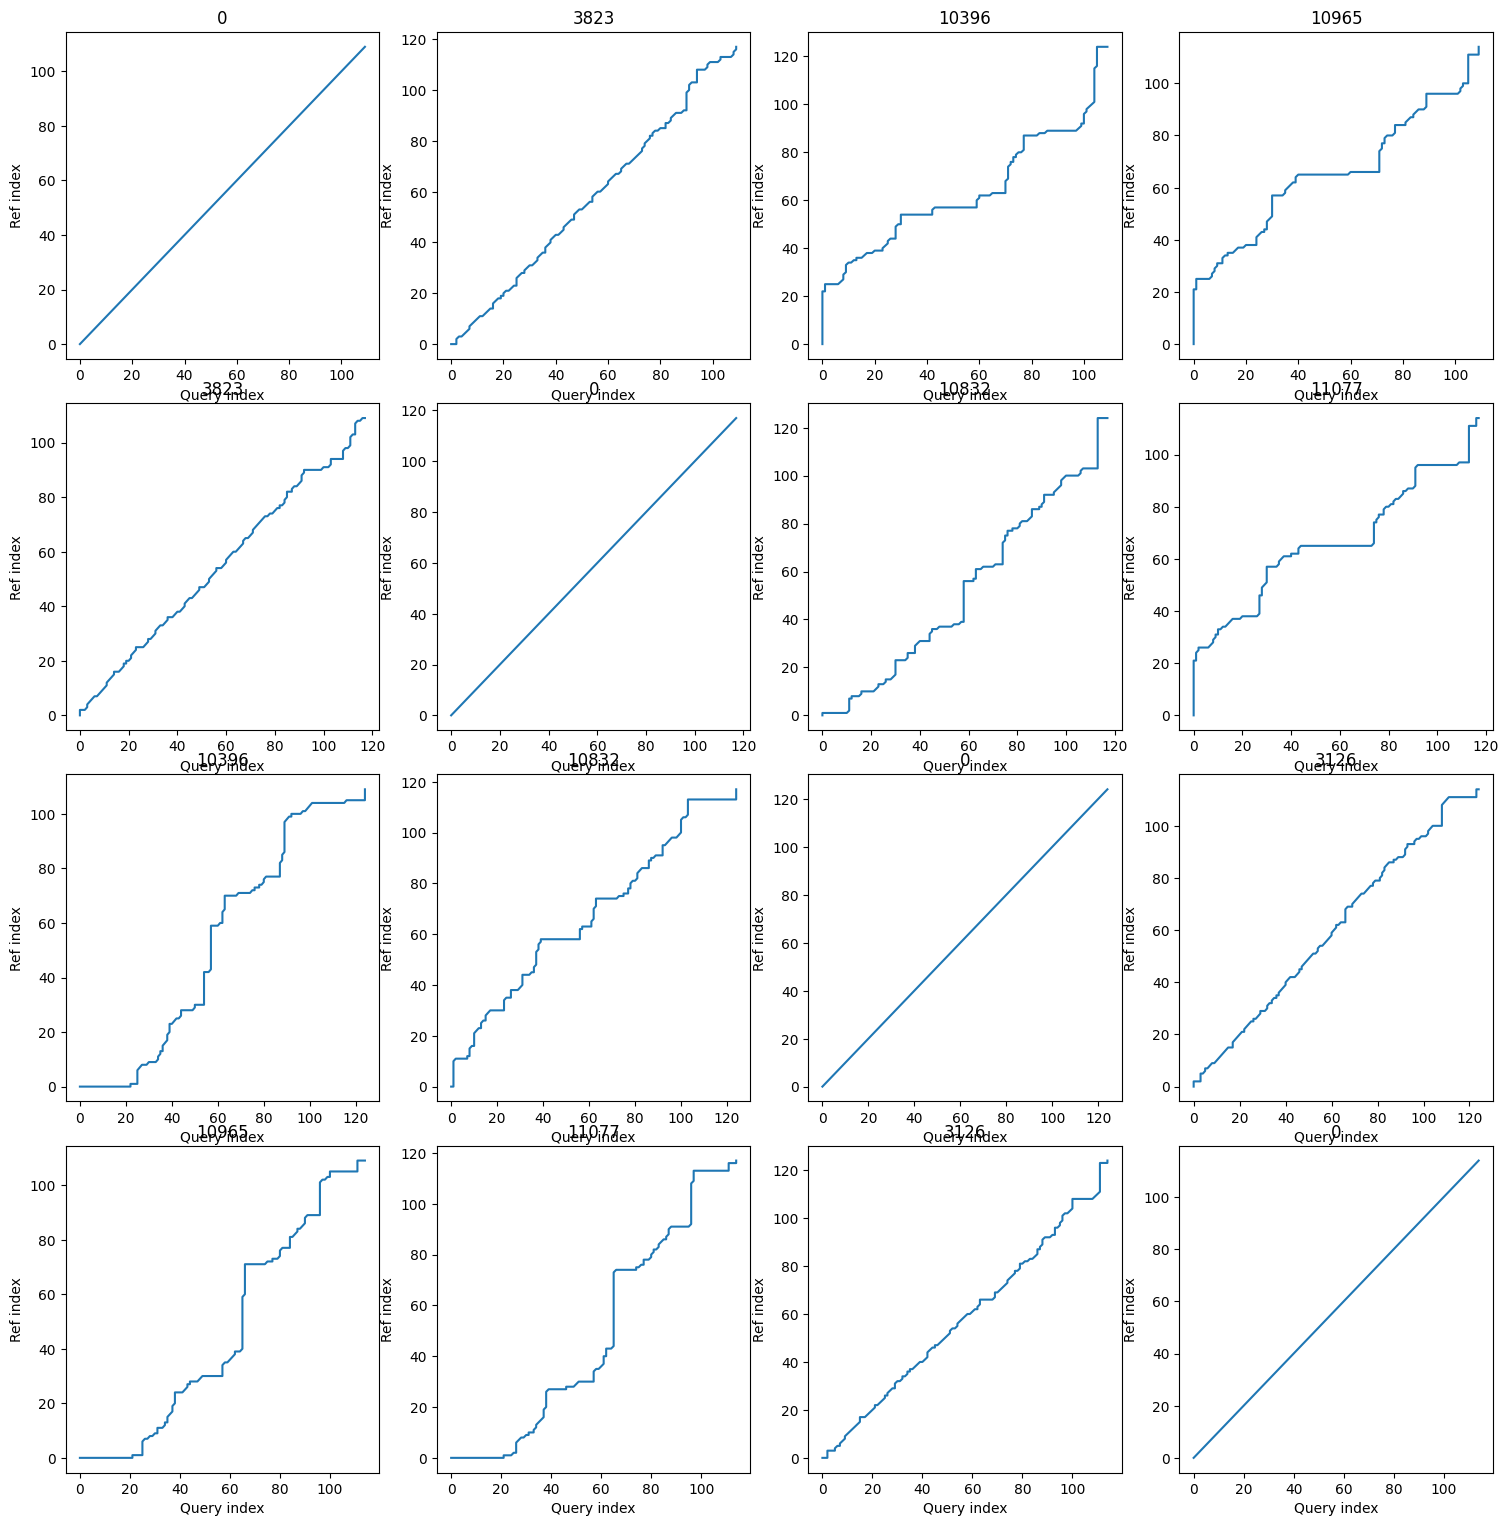

In [40]:
dfs = [mov_df(df, 'circle', i) for i in range(2)] + \
      [mov_df(df, 'z', i) for i in range(2)]

# [mov_df(df, 'double-circle', i) for i in range(2)] + \

fig, axs = plt.subplots(len(dfs), len(dfs), figsize=(15, 15))
fig.tight_layout()
for i, df1 in enumerate(dfs):
    for j, df2 in enumerate(dfs):
        ax = axs[i][j]
        align = dtw.dtw(df1, df2) 
        # https://github.com/DynamicTimeWarping/dtw-python/blob/56d2e09dd4409f2d7bafb465889d696a25ebdd2c/dtw/dtwPlot.py#L79
        ax.plot(align.index1, align.index2)
        ax.set_xlabel("Query index")
        ax.set_ylabel("Ref index")
        ax.set_title(f'{int(align.normalizedDistance)}')

In [42]:
import itertools

keys = [k for k, v in df.groupby(['name', 'n'])]

# for k1, k2 in itertools.combinations_with_replacement(keys, 2):
#     print(k1, k2)

def k_dist(k1, k2):
    return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2)).normalizedDistance

def name(k):
    s, n = k
    return f'{s}_{n}'

records = [{
    'k1': name(k1),
    'k2': name(k2),
    'dist': k_dist(k1, k2),
    }
    for a, b in itertools.combinations_with_replacement(keys, 2)
    for k1, k2 in [(a, b), (b, a)]
    if k1 != k2
]

dist_matrix = pd.DataFrame.from_records(records)

In [43]:
dist_df = dist_matrix.pivot(index='k1', columns='k2', values='dist').fillna(0.0)

<Axes: xlabel='k2', ylabel='k1'>

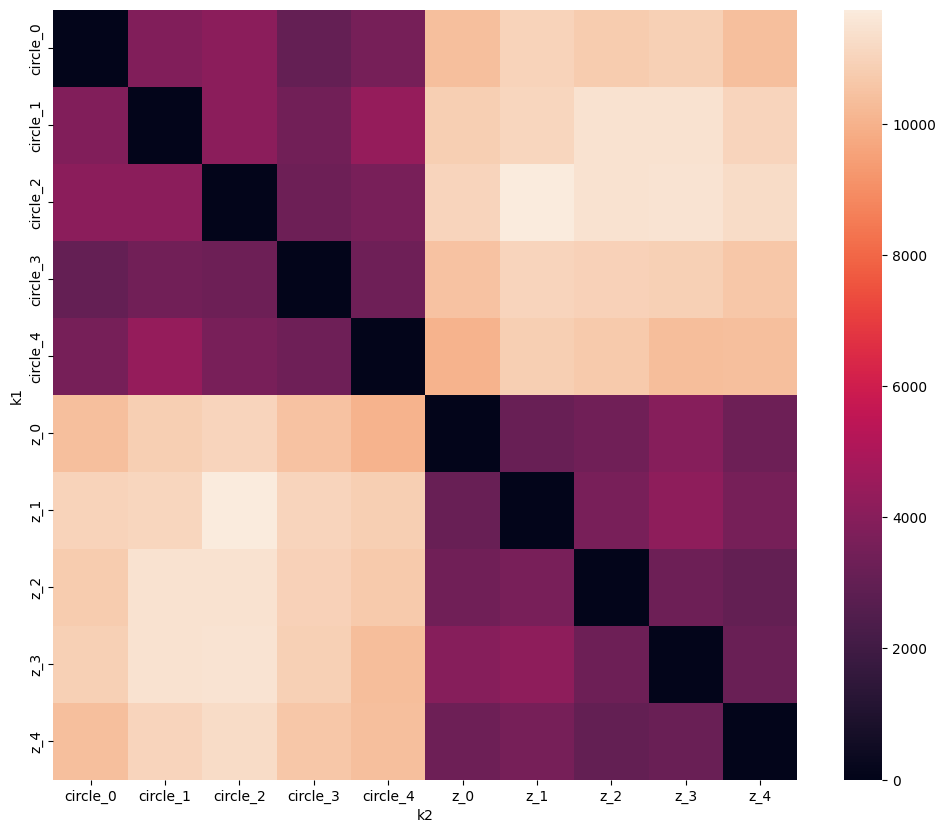

In [44]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(dist_df, ax=ax)

In [53]:
# Which row is the min dist to circle_0?
dist_df.columns[dist_df['circle_0'].argmin()]

'circle_0'